# 异常检测——基于相似度的方法

前面两个task分别从**传统的统计学方法**和**线性方法**来完成异常检测，两类方法从直觉上都比较清楚，也存在一定的局限:
* 在统计定义上的异常检测是无可非议的，但需要实际满足统计假设时结果才有效；
* 线性方法不能反映特征之间的关系；

这次学习的是基于相似度的方法，例如KNN、LOF等都属于这类方法（包括我认为IF也能从这里溯源），大多数异常检测的方法都是基于相似度来完成的。而基于相似度的异常检测方法主要就是分辨“离群值”，思路和辨别准则上同样比较清楚；

## 1. 基于距离的方法

基于距离的方法是一种常见的**适用于各种数据域**的异常检测算法，它基于最近邻距离来定义异常值。 

此类方法不仅适用于**多维数值数据**，在其他许多领域，例如**分类数据**，**文本数据**，**时间序列数据**和**序列数据**等方面也有广泛的应用。   

基于距离的异常检测有这样一个**前提假设**，即异常点的 $k$ 近邻距离要远大于正常点。解决问题的最简单方法是使用嵌套循环。第一层循环遍历每个数据，第二层循环进行异常判断，需要计算当前点与其他点的距离，一旦已识别出多于 $k$ 个数据点与当前点的距离在 $D$ 之内，则将该点自动标记为非异常值。

这样计算的时间复杂度为$O(N^{2})$，**当数据量比较大时，这样计算是及不划算的**。 因此，需要修剪方法以加快距离计算。

接下来是两种优化方法：

**1.1 基于单元的方法**

在基于单元格的方法中，数据空间被划分为单元格，单元格的宽度是阈值 $D$ 和数据维数的函数。具体地说，每个维度被划分成宽度最多为 $\frac{D}{{2 \cdot \sqrt d }}$ 单元格。在给定的单元以及相邻的单元中存在的数据点满足某些特性，这些特性可以让数据被更有效的处理。

以二维情况为例，此时网格间的距离为 $\frac{D}{{2 \cdot \sqrt d }}$ ，需要记住的一点是，网格单元的数量基于数据空间的分区，并且与数据点的数量无关。这是决定该方法在低维数据上的效率的重要因素，在这种情况下，网格单元的数量可能不多。

另一方面，此方法不适用于更高维度的数据。对于给定的单元格，其 $L_{1}$ 邻居被定义为通过最多1个单元间的边界可从该单元到达的单元格的集合。请注意，在一个角上接触的两个单元格也是 $L_{1}$ 邻居。 $L_{2}$ 邻居是通过跨越2个或3个边界而获得的那些单元格。 上图中显示了标记为 $X$的特定单元格及其 $L_{1}$ 和 $L_{2}$ 邻居集。 显然，内部单元具有8个 $L_{1}$ 邻居和40个 $L_{2}$ 邻居。 

然后，可以立即观察到以下性质：

* 单元格中两点之间的距离最多为 $D/2$。
* 一个点与 $L_{1}$ 邻接点之间的距离最大为 $D$。
* 一个点与它的 $Lr$ 邻居(其中$r$ > 2)中的一个点之间的距离至少为$D$。

![示意图](task04.png)

唯一无法直接得出结论的是 $L_{2}$ 中的单元格。 这表示特定单元中数据点的不确定性区域。 对于这些情况，需要明确执行距离计算。 同时，可以定义许多规则，以便立即将部分数据点确定为异常值或非异常值。 

规则如下：
* 如果一个单元格中包含超过 $k$ 个数据点及其 $L_{1}$ 邻居，那么这些数据点都不是异常值。
* 如果单元 $A$ 及其相邻 $L_{1}$ 和 $L_{2}$ 中包含少于 $k$ 个数据点，则单元 $A$ 中的所有点都是异常值。

此过程的第一步是将部分数据点直接标记为非异常值（如果由于第一个规则而导致它们的单元格包含 $k$ 个点以上）。 此外，此类单元格的所有相邻单元格仅包含非异常值。 为了充分利用第一条规则的修剪能力，确定每个单元格及其 $L_{1}$ 邻居中点的总和。 如果总数大于 $k$ ，则所有这些点也都标记为非离群值。

接下来，利用第二条规则的修剪能力。 对于包含至少一个数据点的每个单元格 $A$，计算其中的点数及其 $L_{1}$ 和 $L_{2}$ 邻居的总和。 如果该数字不超过 $k$，则将单元格$A$ 中的所有点标记为离群值。 此时，许多单元可能被标记为异常值或非异常值。

对于此时仍未标记为异常值或非异常值的单元格中的数据点需要明确计算其 $k$ 最近邻距离。即使对于这样的数据点，通过使用单元格结构也可以更快地计算出 $k$ 个最近邻的距离。考虑到目前为止尚未被标记为异常值或非异常值的单元格$A$。这样的单元可能同时包含异常值和非异常值。单元格 $A$ 中数据点的不确定性主要存在于该单元格的 $L_{2}$ 邻居中的点集。无法通过规则知道 $A$ 的 $L_{2}$ 邻居中的点是否在阈值距离 $D$ 内，为了确定单元 $A$ 中数据点与其$L_{2}$ 邻居中的点集在阈值距离 $D$ 内的点数，需要进行显式距离计算。对于那些在 $L_{1}$ 和 $L_{2}$ 中不超过 $k$ 个且距离小于 $D$ 的数据点，则声明为异常值。

需要注意，仅需要对单元 $A$ 中的点到单元$A$的$L_{2}$邻居中的点执行显式距离计算。这是因为已知 $L_{1}$ 邻居中的所有点到 $A$ 中任何点的距离都小于 $D$，并且已知 $Lr$ 中 $(r> 2)$ 的所有点与 $A$上任何点的距离至少为 $D$。因此，可以在距离计算中实现额外的节省。

**1.2 基于索引的方法**

对于一个给定数据集，基于索引的方法利用多维索引结构(如 $\mathrm{R}$ 树、$k-d$ 树)来搜索每个数据对象 $A$ 在半径 $D$ 范围 内的相邻点。

设 $M$ 是一个异常值在其 $D$ -邻域内允许含有对象的最多个数，若发现某个数据对象 $A$ 的 $D$ -邻域内出现 $M+1$ 甚至更多个相邻点，则判定对象 $A$ 不是异常值。

该算法时间复杂度在最坏情况下为 $O\left(k N^{2}\right),$ 其中 $k$ 是数据集维数， $N$ 是数据集包含对象的个数。该算法在数据集的维数增加时具有较好的扩展性，但是时间复杂度的估算**仅考虑了搜索时间，而构造索引的任务本身就需要密集复杂的计算量。**

**1.3 嵌套循环算法NL**

将内存缓冲区空间划分成相等的两部分，数据集分成几个大小和每部分缓冲区相等的逻辑块，通过认真选择调入每一部分缓冲区的次序，使I/O次数最小算法复杂度是 $O\left(k N^{2}\right),$ 其中k为维数，N为数据点数。
  
特点：不需要建立多维索引结构，时间复杂度较大。

## 2. 基于密度的度量

基于密度的方法其实是对基于距离的改进，上一种方法是 $K$ 近邻超过了距离阈值 $D$ ，我们就认为与正常值形成了“离群”的情况，在这里我们是认为如果一个区域（集群）内点的密度过小，那么就容易判断出离群点。

基于密度的算法主要有局部离群因子(LocalOutlierFactor,LOF)，以及LOCI、CLOF等基于LOF的改进算法。下面我们以LOF为例来进行详细的介绍和实践。

**基于距离的检测适用于各个集群的密度较为均匀的情况。**

在下图中，离群点B容易被检出，而若要检测出较为接近集群的离群点A，则可能会将一些集群边缘的点当作离群点丢弃。而LOF等基于密度的算法则可以较好地适应密度不同的集群情况。这就是基于密度的方法在基于距离的方法上的最大改进。

![](task041.png)

接下来我们来梳理密度方法的逻辑。

**2.1 $K$-距离**

对于数据集D中的某一个对象$o$，与其距离最近的k个相邻点的最远距离表示为k-distance(p)，定义为给定点$p$和数据集D中对象$o$之间的距离$d(p,o)$，满足：

* 在集合D中至少有k个点 $o'$，其中$o'$ $∈D{p}$，满足$d(p,o')≤d(p,o)$
* 在集合D中最多有k-1个点$o'$，其中$o'$ $∈D{p}$，满足$d(p,o;)<d(p,o)$
  
但是我个人觉得上述定义不好理解，所谓“$P$点”并不是某一个“定点”，其实应该理解为第$K$个点：

**直观一些理解，就是以对象o为中心，对数据集D中的所有点到o的距离进行排序，距离对象o第k近的点p与o之间的距离就是k-距离。**

![](task042.png)

**2.2 $K$领域**

由k-距离，我们扩展到一个点的集合——到对象o的距离小于等于k-距离的所有点的集合，我们称之为k-邻域：$N_{k − d i s t a n c e ( p )}( P ) = { q ∈ D \backslash{ p } ∣ d ( p , q ) ≤ k − d i s t a n c e ( p )} $。

  在二维平面上展示出来的话，对象o的k-邻域实际上就是以对象o为圆心、k-距离为半径围成的圆形区域。就是说，k-邻域已经从“距离”这个概念延伸到“空间”了。
  
**2.3 可达距离（reachability distance）**：

  有了邻域的概念，我们可以按照到对象o的距离远近，将数据集D内的点按照到o的距离分为两类：

* 若$p_i$在对象o的k-邻域内，则可达距离就是给定点p关于对象o的k-距离；
* 若$p_i$在对象o的k-邻域外，则可达距离就是给定点p关于对象o的实际距离。

给定点p关于对象o的可达距离用数学公式可以表示为：$r e a c h−d i s t_ k ( p , o ) = m a x {k−distance( o ) , d ( p , o )}$ 。
  
这样的分类处理可以简化后续的计算，同时让得到的数值区分度更高。

**2.4 局部可达密度（local reachability density）**：
  我们可以将“密度”直观地理解为点的聚集程度，就是说，点与点之间距离越短，则密度越大。在这里，我们使用数据集D中给定点p与对象o的k-邻域内所有点的可达距离平均值的倒数（注意，不是导数）来定义局部可达密度。
  给定点p的局部可达密度计算公式为：$$lrd_{MinPts}(p)=1/(\frac {\sum\limits_{o∈N_{MinPts}(p)} reach-dist_{MinPts}(p,o)} {\left\vert N_{MinPts}(p) \right\vert})$$

  由公式可以看出，这里是对给定点p进行度量，计算其邻域内的所有对象o到给定点p的可达距离平均值。给定点p的局部可达密度越高，越可能与其邻域内的点 属于同一簇；密度越低，越可能是离群点。
  
**2.5 局部异常因子：**

![](task043.png)

  表示点p的邻域$N_k(p)$内其他点的局部可达密度与点p的局部可达密度之比的平均数。如果这个比值越接近1，说明o的邻域点密度差不多，o可能和邻域同属一簇；如果这个比值小于1，说明o的密度高于其邻域点密度，o为密集点；如果这个比值大于1，说明o的密度小于其邻域点密度，o可能是异常点。

  最终得出的LOF数值，就是我们所需要的离群点分数。在sklearn中有LocalOutlierFactor库，可以直接调用。下面来直观感受一下LOF的图像呈现效果。

  LocalOutlierFactor库可以用于对单个数据集进行无监督的离群检测，也可以基于已有的正常数据集对新数据集进行新颖性检测。在这里我们进行单个数据集的无监督离群检测。
  
## 3.练习 

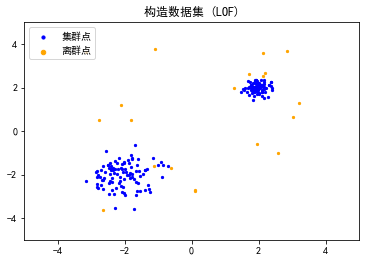

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


np.random.seed(61)

# 构造两个数据点集群
X_inliers1 = 0.2 * np.random.randn(100, 2)
X_inliers2 = 0.5 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers1 + 2, X_inliers2 - 2]

# 构造一些离群的点
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# 拼成训练集
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
# 打标签，群内点构造离群值为1，离群点构造离群值为-1
ground_truth[-n_outliers:] = -1
plt.title('构造数据集 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()